#**Final Project**


#**Fun With Star Clusters, The Ultimate Laboratories for Stellar Astrophysics**

*Astronomy Goals*:

*   Plot color-magnitude diagrams (CMDs) for star clusters of different ages
*   Compare these CMDs to each other determine their relative ages
*   Use an isochrone stellar evolution model to age-date a star cluster

*Coding Goals*:

*   Download astronomy catalogs into Python (again)
*   Interact with and plot data from tables (again)
*   Save plots to your Google Drive





In [1]:
# In this lesson, we are going to save a plot to our Google Drive
# However, we only want to save the final product, 
#   so we will create a True/False flag that will control 
#   whether or not the figures are saved.

save_figures = False  # Only switch this to True when you are ready to save your figures.

# Once you have completed the assignment, set this to True and then rerun the entire notebook:
#   go to the "Runtime" drop-down menu and select "Run all".
# After the notebook runs through every step, go to your Google Drive folder and ensure that the figures were saved properly.

#**Background**

Stars form in clusters at approximately the same time and from the same material. While still gravitationally bound to their birth cluster, these stars then also share a common distance from Earth and pass through a similar amount of interstellar media (intervening gas and dust in the Galaxy, which dims and reddens starlight). For this reason, most of the variables governing a star's appearance and behavior are fixed, aside from mass (stars in binaries can also follow alternative evolutionary pathways; the initial rotation rate also matters). This makes star clusters potentially valuable laboratories for studying stars. "Potentially," because before we can do anything else we first must do the hard work of thoroughly characterizing the cluster and identifying its members. 

Star clusters were historically identified as overdense groupings of stars on the sky (e.g., the Pleiades). Now that we have precise astrometric data from *Gaia*, we can use the parallaxes and proper motions (angular velocities across the sky) to identify with more confidence the members of known star clusters and even to discover new ones. To be identified as a star cluster, the stars are generally found to be at the same distance from Earth and moving together through the Galaxy. To remain gravitationally bound to each other, their spread in velocities must not be too great, otherwise their kinetic energies will exceed their gravitational potential energies and they will escape. This makes parallaxes and proper motions very useful quantities for this work.

Since *Gaia*'s second data release (DR2; April 2018), many teams around the world have mined its astrometric database to identify clusters and their members. In this project, we will use a catalog assembled by Cantat-Gaudin et al. (2020) and published in the journal *Astronomy & Astrophysics* under the title *Painting a portrait of the Galactic disc with its stellar clusters*. We will load catalogs for a variety of nearby star clusters (some of those within 1000 pc), put together their color$-$magnitude diagrams (CMDs), and then use these to explore some basic properties of star clusters before ultimately deriving an age for one. 

#**Setting up our notebook**

We'll start by importing the Python modules we used last time.

**Import relevant Python modules from Assignments 1 and 2**

In [2]:
# Numpy: arrays, numbers, constants, math
import numpy as np

# Matplotlib: plotting
import matplotlib.pyplot as plt

# This disables certain system messages
import warnings
warnings.filterwarnings('ignore')

# Accessing astronomical datasets
# %pip install astroquery
from astroquery.vizier import Vizier


# Reading and working with Astropy tables
from astropy.io import ascii

**Mount your Google Drive**

Your Google Drive can be accessed from this Jupyter Notebook. Files can be read into your session, and files can be written and saved for later (e.g., plots). This is a very important ability, so we will introduce one example in this assignment: saving a plot you create to a *.png file. 

To gain this ability, we must give our permission. Running the cell below will print a URL. Clicking on this should launch a new tab, where you can select your Google account and sign in. This will provide an authorization code: you can either highlight it with your mouse and copy it, or you can click the box icon to the right of the code and it will copy for you. Close the tab and come back to this notebook and paste the code in the box provided below (it will say, "Enter your authorization code:"). You can either paste using the drop-down menu under "Edit" in this notebook, or you can use your standard keyboard shortcuts (e.g., for Mac users, command+v will paste). 

While we're on the subject of keyboard shortcuts, familiarizing yourself with certain commands will improve your working efficiency. For example (for Mac users), you can run a code cell by entering command+return, you can add a new cell by holding command and pressing m then b, and you can delete a cell by holding command and pressing m then d. The drop-down menus provide some other handy shortcuts. 



**Create a folder for this course and for your figures**

If you have not already, it is a good idea to create a folder for this course in your Google Drive. You can place these assignment notebooks there. We will also save figures to this folder in this assignment.

Let's say you add a folder in the main level of your Google Drive called "Astro_Course." It will be located in the following folder location (this can also be referred to as a directory or path):

#**Obtaining the *Gaia* star cluster catalogs**

We are going to use [*Painting a portrait of the Galactic disc with its stellar clusters*](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A...1C/abstract) by Cantat-Gaudin et al. (2020). Following the link to this paper's entry on ADS (the astrophysics data system$-$an online repository of journal articles), you will find the paper's abstract, links to the PDF or HTML versions of the paper, and a button under "Data Products" labeled "CDS." CDS stands for the Centre de Données astronomiques de Strasbourg, which is one of the biggest online data archives for astronomy. There, one can access the data table for this paper and many other datasets as well. The Python $\texttt{astroquery}$ package includes a tool for accessing datasets stored at CDS, including on its VizieR and SIMBAD archives.

**A function to download the catalog for a particular cluster**

The code cell below defines a function, $\texttt{get\_cluster}$, which downloads the membership list for a given star cluster from the Cantat-Gaudin et al. (2020) catalog. The user (you!) must provide the cluster name as a string (that means the name must be wrapped in quotes). Furthermore, the cluster name must match the catalog's format. For one, the catalog uses an underscore instead of whitespace. For example, the cluster NGC 2682 (also known as M67) is listed as "NGC_2682". 

In [3]:
def get_cluster(Cluster_Name):
  vizier_CantatGaudin2020 = 'J/A+A/640/A1/nodup'    # Cantat-Gaudin et al. (2020) - this is the vizier code for the "Portrait" paper.

  # Set up the Vizier query. 
  # First, we want to select only stars in the cluster we are interested in. 
  # Second, Cantat-Gaudin+2020 also provides membership probabilities (ranging from 0 to 1). 
  #   We will only download stars with membership probabilities greater than 50%.
  query_catalog = Vizier(column_filters={'Cluster': Cluster_Name, 'prob':'>0.5'})
  
  # By default, Vizier() only downloads the first 50 rows of a table. 
  # To deactivate the row limit, set it to -1 (i.e., this will tell it to download the full table)
  query_catalog.ROW_LIMIT = -1
  
  # Perform the query
  cluster_catalog = query_catalog.get_catalogs(vizier_CantatGaudin2020)[0]

  # Rename some of the columns to simpler names
  cluster_catalog['pmRA_'].name = 'pmRA'
  cluster_catalog['pmDE'].name = 'pmDec'
  cluster_catalog['Plx'].name = 'Parallax'
  cluster_catalog['RA_ICRS'].name = 'RA'
  cluster_catalog['DE_ICRS'].name = 'Dec'
  
  # Remove some unnecessary columns
  cluster_catalog.remove_columns(['o_Gmag', 'proba', 'Cluster', '_RA.icrs', '_DE.icrs','Teff50'])
  
  # Return the catalog
  return cluster_catalog

**Example: Downloading the catalog for the Praesepe cluster (NGC 2632)**

The cluster name is provided as a string (in quotes), and the function returns the data table. You can see below that the first line printed is *Table length=685*. This tells you that there are 685 stars for this particular cluster in this particular catalog. Other catalogs applied different membership criteria and have found differing numbers of members.


Note that under the table column names, units are provided. For example, parallax is measured in milliarcseconds (mas) or 1/1000 of an arcsecond.

Also note that in Cantat-Gaudin et al. (2020), Praesepe is listed under its NGC name: "NGC_2632". Many clusters have multiple names; we are going to refer to the cluster by the name most commonly used by modern astronomers, but please note that Cantat-Gaudin and others often use alternative names. The NGC designation, by the way, is from the *New General Catalogue of Nebulae and Clusters of Stars*, first assembled by William and Caroline Herschel starting in the 18th century.

In [4]:
# Download the data table for Praesepe, aka NGC 2632:
Praesepe = get_cluster('NGC_2632')

# Typing the name of a table (or any object) prints out the contents (or a summary of the contents for large collections like this one).
Praesepe

RA,Dec,GaiaDR2,Parallax,pmRA,pmDec,RV,Gmag,BP-RP
deg,deg,,mas,mas / yr,mas / yr,km / s,mag,mag
float64,float64,int64,float64,float64,float64,float64,float64,float64
130.96559423303,17.65554345030,658570974996041344,5.5616091719566398,-36.0951463406402979,-11.4647544371596002,--,16.9278300,2.7468777
130.28844967979,17.57132332981,658602070559194496,5.1902136361683802,-37.6735381214203997,-12.1980020122219006,--,17.9982280,3.033121
130.41020914492,17.63997442869,658607950370340608,5.3420907729709803,-36.169782997530497,-11.4013086809732993,--,14.5262630,1.9543886
130.35880803061,17.80347466009,658615440793299712,5.5255178627505197,-37.2407743397464017,-11.7723426012894006,--,16.5640830,2.7845163
131.04968310132,17.90213538700,658628905514597376,5.2502808479682903,-35.8790774968653992,-11.4402870923511006,35.4208499056807966099,9.8143340,0.6274204
130.57294256495,17.98745732057,658641996575437440,5.4342666227954197,-36.4579927840669029,-11.5855386597089005,--,16.6756610,2.7992096
130.94716498833,18.04997813564,658645574283870720,5.6033780118328496,-37.161618214829403,-11.6285410147179,--,17.3063720,3.0871773
129.30751563824,17.51348567905,659248858275152128,5.2896850519082301,-35.4394605979003998,-11.7257846800732999,--,13.2668460,1.4617271


**Column descriptions**



*   *RA, Dec*: Equatorial coordinates of Right Ascension and Declination, measured in decimal degrees (RA goes from 0 to 360$^\circ$, and Dec goes from $- $90 to 90$^\circ$). These are the angular sky coordinates.
*   *GaiaDR2*: The *Gaia* Source ID number from the second data release catalog. This is a unique identifier for each star in the catalog.
*   *Parallax*: The parallax, measured in mas, can be inverted to estimate the distance to a source.
*   *pmRA, pmDec*: the proper motion in the RA and Dec directions, measured in mas per year. These are angular velocities of the stars across the sky.
*   *RV*: radial velocity, the speed of the stars along the line of sight, measured in km/s. 
*   *Gmag*: the apparent $G$ magnitude. 
*   *BP-RP*: the *Gaia* color, calculated by subtracting the $RP$ magnitude from the $BP$ magnitude (review Assignment 2 for more information). 

**Using data in a table**

Review Assignment 2 for an example of using an astropy Table, like this one, to access and plot data. That assignment also provides guidance on making high-quality figures (bigger sizes, bold borders, bigger labels, etc).




#**Section (1): Plotting the CMD for Praesepe**
Praesepe, the Beehive Cluster, is a well-known cluster in the constellation of Cancer. In fact, it is one of the first objects Galileo observed when he started observing celestial objects with his telescope. Because it is nearby and had a pretty extensive set of members, it is one of the benchmark clusters for stellar astrophysics.

In [5]:
# How many stars are in this catalog for Praesepe?
# We know the answer because it is printed above, but how do you calculate it?
# len gives us the "length" of the catalog
len(Praesepe)

685

In [36]:
# Using parallax, calculate the median distance to Praesepe and its standard deviation.

def inverse(n: float) -> float:
    return 1000/n

distance = 1000/Praesepe["Parallax"] # Parsec
median = np.median(distance)
standard_deviation = distance.std()

median, standard_deviation


(186.8963167925298, 4.923910264657727)

**Plot the CMD**

The CMD is the starting point for virtually all investigations involving a stellar population. Here we will start by plotting our standard *Gaia* $G$ vs $BP-RP$ CMD, using the apparent $G$ magnitude. The code cell below provides an outline for you. Fill in the needed pieces to make the figure.

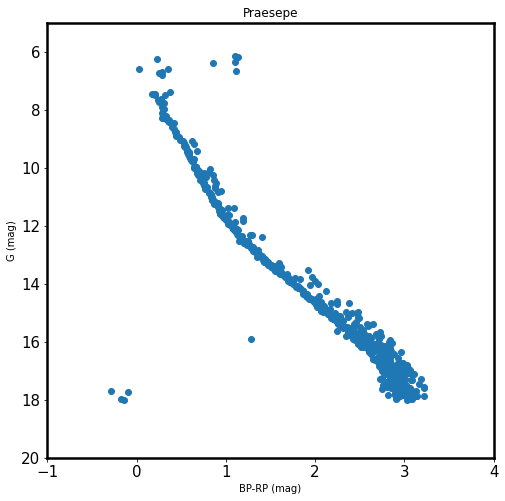

In [7]:
##### Plot BP-RP vs Gmag #####

### Make a nice canvas for the figure
figure, axis = plt.subplots(figsize=(8,8))

### Add the data
axis.scatter(Praesepe["BP-RP"], Praesepe["Gmag"]) # add in your data here and delete the hashtag to activate the line.

### Set the x and y limits
axis.set_xlim([-1, 4]) # after you plot the full sample, choose a minimum and maximum BP-RP and activate this line
axis.set_ylim([5, 20]) # same but for Gmag; recall that bright stars go on top and faint stars go on the bottom of a CMD
axis.invert_yaxis()

### Add axis labels
axis.set_xlabel("BP-RP (mag)") # Add axis labels. you can use the fontsize= keyword to change the font size.
axis.set_ylabel("G (mag)")

### Add title
axis.set_title("Praesepe") # Add a title.

# Make plot look nice
axis_border_width = 2.5
fontsize_axis_labels = 15
axis.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)

axis.spines['top'].set_linewidth(axis_border_width)
axis.spines['left'].set_linewidth(axis_border_width)
axis.spines['right'].set_linewidth(axis_border_width)
axis.spines['bottom'].set_linewidth(axis_border_width)

# If you want to save this figure, you can place your figure.savefig() command here. 
# It is not required for this assignment.

# Conclude the figure
figure.show()

Your figure should look like this: 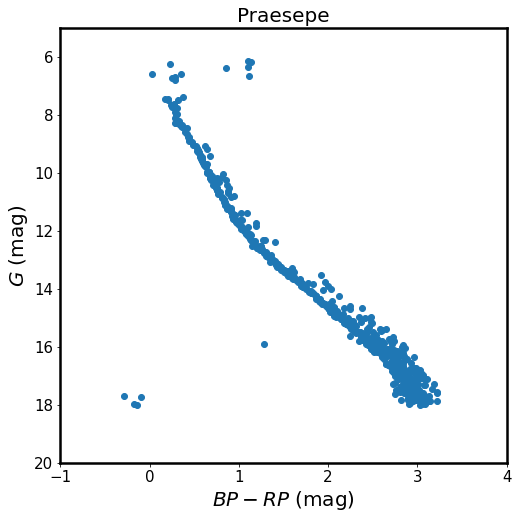

*Question*: Why is it OK for us to plot apparent $G$, rather than absolute $G$, in this CMD? 

> Double-click to enter your answer here

To justify your answer, calculate the physical depth of the cluster and compare it to its median distance from Earth.

In [41]:
# Calculate the physical depth of Praesepe and compare it to its median distance from Earth

depth = distance.max() - distance.min() 
compare = depth/median

print(compare)


0.14535366722333198


#**Section (2): Comparing apparent and absolute magnitude CMDs: the Hyades**
The Hyades, in Taurus, is another benchmark cluster, largely because of its proximity to Earth. In the catalog, the Hyades cluster is called "Melotte_25". Download the cluster and plot its apparent CMD next to its absolute CMD. 

In [9]:
# Download the Hyades catalog (listed as "Melotte_25")

Hyades = get_cluster('Melotte_25')

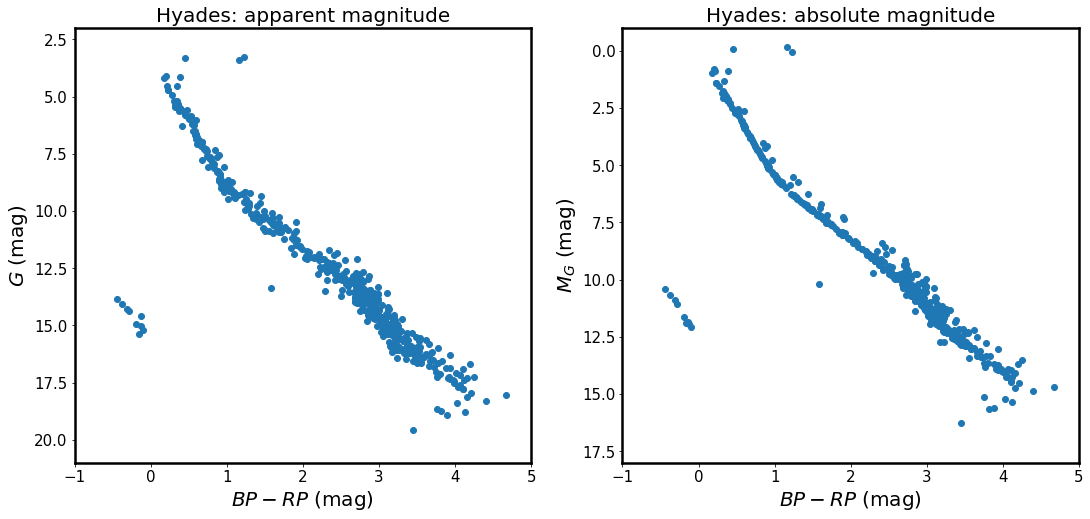

In [42]:
# Plot side-by-side the apparent-G CMD and absolute-G CMDs:

# Make a nice canvas for the side-by-side figure
figure, (axis_apparent, axis_absolute) = plt.subplots(1,2, figsize=(18,8)) # here we make a grid of panels: 1 row x 2 columns. 
# To work on the left panel, use the axis_apparent object following the guidance below; for the right panel use axis_absolute.
#

# Add titles to each panel:
axis_apparent.set_title('Hyades: apparent magnitude',fontsize=20)
axis_absolute.set_title('Hyades: absolute magnitude',fontsize=20)

# # Add the apparent-G CMD: BP-RP vs Gmag
axis_apparent.scatter(Hyades["BP-RP"], Hyades["Gmag"])

# # Add the absolute-G CMD: BP-RP vs M_G
M_G = Hyades['Gmag'] - 5*np.log10(100/Hyades['Parallax'])  # create a variable called M_G which will be the absolute magnitudes for the Hyades
# # Plot BP-RP vs M_G:
axis_absolute.scatter(Hyades['BP-RP'], M_G)


# # After you have run the cell with the plots, set the x and y limits for each panel and rerun.
# # Apparent: Set the x and y limits
axis_apparent.set_xlim([-1, 5])
axis_apparent.set_ylim([2, 21])
axis_apparent.invert_yaxis()

# # Absolute: Set the x and y limits
axis_absolute.set_xlim([-1, 5]) # This should be the same as the left panel
axis_absolute.set_ylim([-1, 18]) # But this will be different
axis_absolute.invert_yaxis()

# # Apparent: Add axis labels
axis_apparent.set_xlabel('$BP - RP$ (mag)', fontsize=20)
axis_apparent.set_ylabel('$G$ (mag)', fontsize=20)

# # Absolute: Add axis labels
axis_absolute.set_xlabel('$BP - RP$ (mag)', fontsize=20)
axis_absolute.set_ylabel('$M_G$ (mag)', fontsize=20)


# # Make plot look nice
axis_border_width = 2.5
fontsize_axis_labels = 15
axis_apparent.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis_apparent.spines['top'].set_linewidth(axis_border_width)
axis_apparent.spines['left'].set_linewidth(axis_border_width)
axis_apparent.spines['right'].set_linewidth(axis_border_width)
axis_apparent.spines['bottom'].set_linewidth(axis_border_width)
# # Copy the five lines above and paste them below this line, 
# #   then modify the axis names to make the right-hand panel bold.

axis_absolute.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis_absolute.spines['top'].set_linewidth(axis_border_width)
axis_absolute.spines['left'].set_linewidth(axis_border_width)
axis_absolute.spines['right'].set_linewidth(axis_border_width)
axis_absolute.spines['bottom'].set_linewidth(axis_border_width)


# # Conclude the figure
figure.show()

**Main sequence outliers**

In the right panel, the absolute CMD shows a main sequence that is much tighter than is found by simply plotting the apparent $G$ magnitudes. In fact, the main sequence looks like someone drew a curve on the screen with a marker. However, there are some noteable outliers. 

*What are the stars at ($BP-RP$, $M_G$) = (1, 0)?*

> These are the giants

*What is that line of stars in the lower left corner (blue and faint)?*

> These are the white dwarf stars

The ones that are probably *hardest* to interpret are the ones that sit just above the main sequence. For example, at $BP-RP$ = 2, the main sequence has a value of about $M_G = 8$ mag, but there is a star with a slightly smaller $M_G$ at that same color. In other words, this star is brighter than you would expect given its color, which is a telltale sign of an unresolved binary: two stars close enough together that the photometric measurement cannot distinguish them. 

*Question*: If the two stars that make up the binary system have the same mass, and therefore the same luminosity, use the relationship between flux and magnitude to show that you expect the offset between the unresolved binary system and a main-sequence star of the same color to be approximately 0.75 mag.



In [45]:
# what is the magnitude offset of a binary where the component stars are equally bright?
2.5*np.log10(2)

0.752574989159953

Later on you will be fitting isochrones to the CMDs of various clusters. Keep in mind when doing so that what you want to fit (to the extent possible) is *the single star main sequence*, i.e., the sequence that forms the bottom edge of the main sequence. Binary stars, which give the main sequence its thickness, can evolve quite differently from single stars (because of mass transfers), and therefore are not as reliable an indicator of the age of the cluster.

#**Section (3): Comparing CMDs for clusters young and old**

Plot absolute $M_G$ CMDs *on one figure* for the following clusters:

1.   Pleiades ("Melotte_20")
2.   M48 ("NGC_2548")
3.   NGC 6811 ("NGC_6811")
4.   NGC 752 ("NGC_752")
5.   M67 ("NGC_2682")

It is hard to keep track of these various names, but it is also useful if you can! These are some of the most important benchmark clusters in astrophysics, and they come up in casual conversations all the time (well, among some people).

To overlay multiple plots on one figure panel, simply add multiple plot() or scatter() commands. By default, the colors will cycle through a series; you can also reset the color manually using the keyword c='red' or an alternative color. For a list of color options, you can Google "matplotlib colors."

**Get catalogs for the clusters**

In [46]:
# M48 (listed as "NGC_2548")
M48 = get_cluster('NGC_2548')

# NGC_6811 (listed as "NGC_6811")
NGC_6811 = get_cluster('NGC_6811')

# NGC_752 (listed as "NGC_752")
NGC_752 = get_cluster('NGC_752')

# M67 (listed as "NGC_2682")
M67 = get_cluster('NGC_2682')

# Pleiades ("NGC 1432")
Pleiades = get_cluster('Melotte_20')

**Plot the CMDs for these clusters in one panel**

Add a legend to the figure that maps point color to cluster name. The code that creates the legend is provided. To make it work, a label keyword must be added to each cluster's axis.scatter() command like so:

> $\texttt{axis.scatter(x_data, y_data, label="Here is my legend label")}$

Once each label is added to the axis.scatter() commands, then axis.legend() will do the rest.



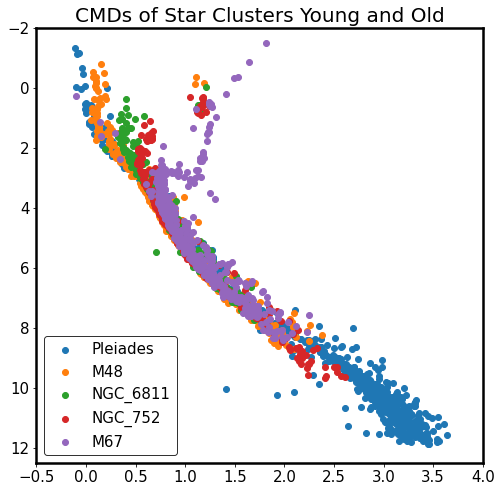

In [47]:
# Plot the CMDs for the above clusters:

# Make a nice canvas for the figure
figure, axis = plt.subplots(figsize=(8,8))

# Add title
axis.set_title('CMDs of Star Clusters Young and Old',fontsize=20)

# Add Pleiades: plot the absolute-G CMD: BP-RP vs M_G (not just Gmag)
# Remember to add a legend label to your CMD: axis.scatter(x_data, y_data, label='Here is my legend label')
axis.scatter(Pleiades["BP-RP"], Pleiades['Gmag'] - 5*np.log10(100/Pleiades['Parallax']), label="Pleiades")

# Add M48: plot the absolute-G CMD: BP-RP vs M_G
axis.scatter(M48["BP-RP"], M48['Gmag'] - 5*np.log10(100/M48['Parallax']), label="M48")

# Add NGC 6811: plot the absolute-G CMD: BP-RP vs M_G
axis.scatter(NGC_6811["BP-RP"], NGC_6811['Gmag'] - 5*np.log10(100/NGC_6811['Parallax']), label="NGC_6811")

# Add NGC 752: plot the absolute-G CMD: BP-RP vs M_G
axis.scatter(NGC_752["BP-RP"], NGC_752['Gmag'] - 5*np.log10(100/NGC_752['Parallax']), label="NGC_752")

# Add M67: plot the absolute-G CMD: BP-RP vs M_G
axis.scatter(M67["BP-RP"], M67['Gmag'] - 5*np.log10(100/M67['Parallax']), label="M67")

# Add a legend
axis.legend(loc='lower left', fontsize=15, edgecolor='black')

# Set the x and y limits
axis.set_xlim(-0.5, 4) 
axis.set_ylim(-2, 12.5) 
axis.invert_yaxis()

# Add axis labels
# axis.scatter(x_data, y_data, label="Here is my legend label")

# Make plot look nice
axis.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis.spines['top'].set_linewidth(axis_border_width)
axis.spines['left'].set_linewidth(axis_border_width)
axis.spines['right'].set_linewidth(axis_border_width)
axis.spines['bottom'].set_linewidth(axis_border_width)

# Save the figure to your drive
if save_figures == True:
  file_name = my_folder + "CMDs_of_Clusters_Young_and_Old.png"
  figure.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)

# Conclude the figure
figure.show()

This exercise reproduces a classic figure by Johnson & Sandage, which appeared in a few varieties during the 1950s; see, for example, [*The galactic cluster M 67 and its significance for stellar evolution*](https://ui.adsabs.harvard.edu/abs/1955ApJ...121..616J/abstract) (Johnson & Sandage 1955), and [*The Color-Magnitude Diagrams of Galactic and Globular Clusters and their Interpretation as Age Groups*](https://ui.adsabs.harvard.edu/abs/1958RA......5...41S/abstract) (Sandage 1958). Take a look$-$your plot should look similar!

*Question*: What is the main difference between these clusters? 

> The main difference is the depth of the Pleiades and the subgaiants of M67

*Question*: Several of these clusters have giants, but only one has subgiants. Which one, and why?

> M-67. This cluster is older and these clusters have had time to evolve off the main sequence.

*Question*: Why do the clusters largely overlap at $M_G > 4$?

> These clusters are all to young to have had their stars evolve off the main sequence yet.

#**Section (4): Overlaying an isochrone on a cluster of your choice to derive its age**
Isochrones are stellar evolution models that tabulate a star's fundamental properties (e.g., luminosity, surface gravity, effective temperature) and observable properties (photometric color and absolute magnitude) at a specific age for a range of masses. The models are initialized at an early age and then evolved forward in time. 

One popular isochrone model is called PARSEC, and can be queried from a website: http://stev.oapd.inaf.it/cgi-bin/cmd_3.6

To simplify the process, we queried the PARSEC isochrone model by selecting the appropriate photometric system (*Gaia* DR2 with Evans+2018 passbands), with zero interstellar extinction, solar metallicity, and ages ranging from 100 Myr to 10 Gyr logarithmically spaced by 0.02 dex (i.e., log ages range from 8.0 to 10.0 with steps of 0.02). We then modified the resulting file by renaming a few columns to be more easy to interpret, deleting unneeded columns, and removing the # hashtag at the row line that has the column names so that it can be more easily read into Python using the tools we are familiar with. We then placed this file online so that it can be accessed. 

**Load the Gaia DR2 isochrone**

In [48]:
# The URL where we have placed the modified isochrone file
url = "https://github.com/jasoncurtis/Lessons/blob/main/GaiaDR2_Isochrones.dat?raw=true"
# Read the file using astropy.ascii.read()
isochrone_table = ascii.read(url, delimiter=r'\s')

**Define some useful functions for working with isochrones**

In [49]:
# Define a function that locates the place in an array where the entry is closest to a requested value:
def find_element(value, array):
  absolute_difference = abs(array - value)
  location_of_element_nearest_to_value = np.argmin(absolute_difference)
  return location_of_element_nearest_to_value

In [50]:
# Define a function that pulls out one isochrone (one age) out of the grid.

# This function will also introduce interstellar extinction (dims Gmag) and reddening (increases BP-RP).
# This is parameterized with $A_V$, the extinction in the visual $V$ band. 
# The extinction in other bands can be calculated from A_V using "extinction coefficients"


def get_isochrone(age, Av = 0.0):
  # Note: Input age must be in millions of years (Myr)

  # 
  unique_ages_in_isochrone_table = np.unique(isochrone_table['log_Age'])
  
  #
  location_of_nearest_age_in_isochrone = find_element(age, 10**unique_ages_in_isochrone_table/1e6)
  
  # 
  nearest_age_in_isochrone = unique_ages_in_isochrone_table[location_of_nearest_age_in_isochrone]

  # 
  find_matching_ages = np.where((isochrone_table['log_Age'] == nearest_age_in_isochrone) & 
                                (isochrone_table['label']<7)
                                )[0]

  # extract isochrone at the given age
  isochrone_at_input_age = isochrone_table[find_matching_ages]

  # 
  isochrone_at_input_age['BP-RP'] = isochrone_at_input_age['G_BPmag'] - isochrone_at_input_age['G_RPmag']

  # Correct photometry for interstellar reddening and extinction
  isochrone_at_input_age['Gmag'] += 0.86*Av
  isochrone_at_input_age['BP-RP'] += 0.415*Av

  isochrone_at_input_age.remove_columns(['G_BPmag', 'G_RPmag'])

  # return
  return isochrone_at_input_age



**Correcting for extinction and reddening caused by interstellar dust**

The above function can also add interstellar extinction (dims $G$ mag) and reddening (increases $BP-RP$ color) to the isochrone. This is parameterized with $A_V$, the extinction in the visual $V$ band. The extinction in other bands can be calculated from $A_V$ using "extinction coefficients": $A_G = 0.86 \times A_V$. 

Interstellar dust reddens star light because the extinction coefficient is larger for bluer bands than redder bands; in other words, dust is more effective at scattering blue light (think of sunsets). The net effect is to redden star light; this is called a "color excess" because the photometric color appears larger than it should be intrinsically for a star, or other astronomical sources. The color excess, e.g., $E(B-V)$ or $E(BP-RP)$ in our case, can be estimated using extinction coefficients for the individual bands. For us, the result is $E(BP-RP) \approx 0.415 \times A_V$.

Instead of correcting the observed photometry, the approach we take in this assignment is to introduce the interstellar dust reddening and extinction to the isochrone model. Therefore, you can simply use the $\texttt{Av = }$ keyword to introduce extinction/reddening to the model and overlay it directly on your CMDs (plotted without modification).


**Column descriptions**


*   *log_Age*: log$_{10}$ of the age in years: e.g., 100 million years (Myr) = 8.0
*   *Initial_Mass*: mass the star was born with in solar units (2.0 = twice the Sun's present day mass). 
*   *Mass*: star's mass at the current age in the model. Stars lose mass over time, more so in their latest stages of evolution.
*   *log_Lum*: logarithm of the star's luminosity in solar units (2.0 = twice the Sun's present day luminosity)
*   *log_Temp*: log$_{10}$ of the surface effective temperature in Kelvin (K).
*   *log_g*: log$_{10}$ of the surface gravity in cgs units.
*   *label*: this integer marks off discrete phases of stellar evolution (e.g., pre main sequence, main sequence, subgiant, red giant, AGB, etc.)
*   *Gmag*: *Gaia* $G$ band photometric magnitude
*   *BP-RP*: *Gaia* $BP-RP$ photometric color.




In [17]:
# Example 1: Let's get a 100 Myr isochrone
isochrone_100Myr = get_isochrone(100)

# Print summary
isochrone_100Myr

log_Age,Initial_Mass,Mass,log_Lum,log_Temp,log_g,label,Gmag,BP-RP
float64,float64,float64,float64,float64,float64,int32,float64,float64
8.0,0.0900000036,0.09,-2.755,3.4013,4.705,0,13.61,4.223000000000001
8.0,0.0931723565,0.093,-2.73,3.4048,4.708,0,13.546,4.222999999999999
8.0,0.1000000015,0.1,-2.675,3.4126,4.715,0,13.409,4.226000000000001
8.0,0.1009420455,0.101,-2.668,3.4135,4.716,0,13.392,4.226000000000001
8.0,0.1116045266,0.112,-2.593,3.4232,4.724,0,13.129,4.098000000000001
8.0,0.1200000122,0.12,-2.538,3.431,4.731,0,12.887,3.9290000000000003
8.0,0.1400000006,0.14,-2.432,3.4434,4.741,0,12.474,3.699
8.0,0.142202422,0.142,-2.421,3.4447,4.742,0,12.432,3.676
8.0,0.1599999964,0.16,-2.338,3.4543,4.75,0,12.114,3.4960000000000004


In [18]:
# Example 2: Let's get a 100 Myr isochrone with Av = 1.0
isochrone_100Myr_Av1 = get_isochrone(100, Av=1.0)

# Print the first few lines
isochrone_100Myr_Av1[0:3]

# Note that the Gmag and BP-RP columns have changed. 

log_Age,Initial_Mass,Mass,log_Lum,log_Temp,log_g,label,Gmag,BP-RP
float64,float64,float64,float64,float64,float64,int32,float64,float64
8.0,0.0900000036,0.09,-2.755,3.4013,4.705,0,14.469999999999999,4.638000000000001
8.0,0.0931723565,0.093,-2.73,3.4048,4.708,0,14.405999999999999,4.637999999999999
8.0,0.1000000015,0.1,-2.675,3.4126,4.715,0,14.269,4.641000000000001


**Question: Plot the *Gaia* CMD for the 100 Myr isochrone**

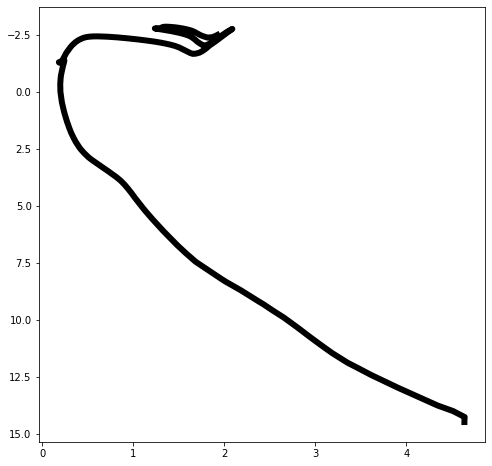

In [30]:
# No need for all the fancy stuff, just use defaults:

plt.figure(figsize=(8,8))

# Plot G vs BP-RP from isochrone_100Myr:

plt.plot(isochrone_100Myr_Av1["BP-RP"], isochrone_100Myr_Av1["Gmag"], c='black',linewidth=6)

plt.plot()

#plt.ylim([-3, 16])  # note that since we didn't create figure and axis objects, to reset the y-limit, we use plt.ylim() NOT plt.set_ylim().
plt.gca().invert_yaxis()

plt.show()

**Plot the CMD of a cluster from the list below and overlay isochrones on it until you find the best-fitting combination of age and amount of foreground interstellar extinction/reddening for that cluster**. 



*   NGC_3532
*   NGC_2548
*   NGC_6811
*   NGC_752
*   Ruprecht_147



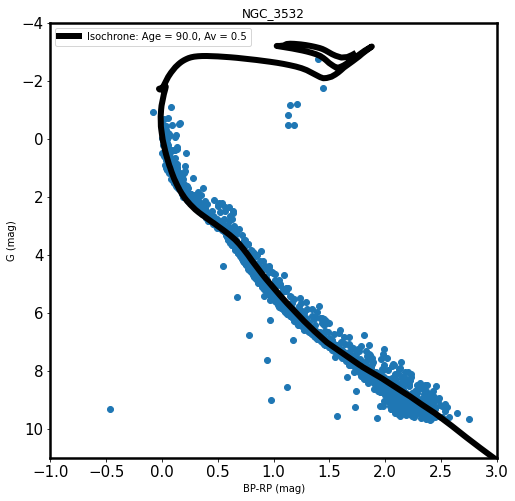

In [56]:
# Pick a cluster from the list above. 

# Download its catalog
NGC_3532 = get_cluster('NGC_3532')

# Plot its CMD

figure, axis = plt.subplots(figsize=(8,8))
axis.scatter(NGC_3532["BP-RP"], NGC_3532['Gmag'] - 5*np.log10(100/NGC_3532['Parallax'])) # add in your data here and delete the hashtag to activate the line.
axis.set_xlim([-1, 3]) # after you plot the full sample, choose a minimum and maximum BP-RP and activate this line
axis.set_ylim([-4, 11]) # same but for Gmag; recall that bright stars go on top and faint stars go on the bottom of a CMD
# axis.invert_yaxis()
axis.set_xlabel("BP-RP (mag)") # Add axis labels. you can use the fontsize= keyword to change the font size.
axis.set_ylabel("G (mag)")
axis.set_title("NGC_3532") # Add a title.

# If you want to save this figure, you can place your figure.savefig() command here. 
# It is not required for this assignment.

# Conclude the figure
figure.show()

# Load the isochrone
Age = 90.0 # Myr -- modify this number and Av until you get a good fit
Av = 0.5 # mag  -- modify this number and Age above until you get a good fit
my_isochrone = get_isochrone(Age, Av=Av)

# Overlay the isochrone model
# Vary the Age and Av interstellar extinction/reddening parameters to get a good fit.
axis.plot(my_isochrone["BP-RP"], my_isochrone["Gmag"], c='black',linewidth=6, label = f'Isochrone: Age = {Age}, Av = {Av}')
axis.invert_yaxis()
axis.legend()

# Add all the usual things (title, labels, limits, borders)
axis_border_width = 2.5
fontsize_axis_labels = 15
axis.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis.spines['top'].set_linewidth(axis_border_width)
axis.spines['left'].set_linewidth(axis_border_width)
axis.spines['right'].set_linewidth(axis_border_width)
axis.spines['bottom'].set_linewidth(axis_border_width)

# Save the figure


# Conclude the figure
figure.show()


Your plot should look like this: 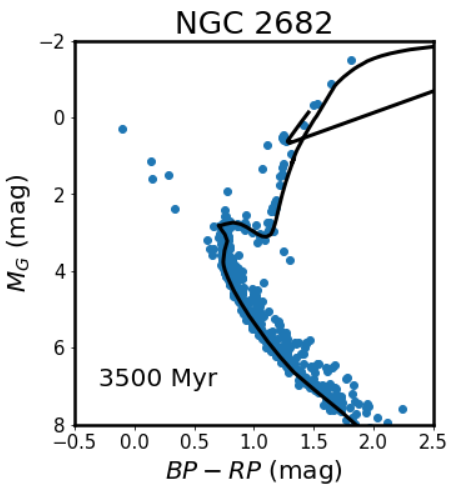

*Question*: Briefly describe why you selected your best-fit isochrone, and provide an estimate of the uncertainty on the corresponding age. How could you improve this fit?

> Your response